In [40]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
def multi_indexing(df: pd.DataFrame, stats: dict[str, str]) -> pd.DataFrame:
    # set the multi index based on event & player name
    multiIndexDf = df.set_index(['EVENT', 'PLAYER NAME'], inplace=False)
    
    rtnDf = multiIndexDf[[*stats.keys()]]
    
    return rtnDf.rename(columns = stats)

In [27]:
csvs = ["driving_distance", "driving_accuracy", "greens_in_regulation", "proximity_to_the_hole","scrambling","sand_saves","putts_per_round"]

statsMap = {
  "driving_distance" : {
    'AVG.' : 'Driving Distance',
    'TOTAL DRIVES' : 'Total Drives'
  },
  "driving_accuracy": {
    '%' : 'Fairways Hit (%)',
    'FAIRWAYS HIT':  'Fairsways Hit',
    'POSSIBLE FAIRWAYS' : 'Possible Fairways'
  },
  "greens_in_regulation": {
    '%' : 'Greens Hit'
  },
     "proximity_to_the_hole": {
    'AVG' : 'Hole Proximity',
    'GIR RANK': 'GIR Rank'
  },
    "putts_per_round": {
    'AVG' : 'Putts'
  },
  "sand_saves": {
    '%' : 'Sand Saves (%)',
    '# SAVES': 'Sand Saves',
    '# BUNKERS' : 'Bunkers'
  },
  "scrambling" : {
    '%' : 'Scrambling (%)',
    'PAR OR BETTER' : 'Scarmbling',
    'MISSED GIR' : 'Missed GIR'
  },
}

IMPORTANT NOTES

- each stat is a 4 day average
- only players who make it to the final round (4 rounds) are considered

In [28]:
# set up inital scoring df
scoringDf = pd.read_csv('../data/raw_data/scoring_average.csv')
aggratedData = multi_indexing(scoringDf, {'AVG': 'Score'})

for file in csvs:
    currDf = pd.read_csv(f'../data/raw_data/{file}.csv')
    currDict = statsMap[file]
    
    cleanedDf = multi_indexing(currDf, currDict)
    aggratedData = pd.merge(aggratedData, cleanedDf, on=['EVENT', 'PLAYER NAME'])

aggratedData.head()

Score  Driving Distance  Total Drives  \
EVENT     PLAYER NAME                                                 
U.S. Open Matt Fitzpatrick   65.903             310.5             8   
          Scottie Scheffler  66.153             313.3             8   
          Will Zalatoris     66.153             306.3             8   
          Hideki Matsuyama   66.653             295.9             8   
          Rory McIlroy       66.903             300.9             8   

                             Fairways Hit (%)  Fairsways Hit  \
EVENT     PLAYER NAME                                          
U.S. Open Matt Fitzpatrick              69.64             39   
          Scottie Scheffler             67.86             38   
          Will Zalatoris                55.36             31   
          Hideki Matsuyama              51.79             29   
          Rory McIlroy                  55.36             31   

                             Possible Fairways  Greens Hit Hole Proximity  \
EVENT     PLAYER NAME                                                       
U.S. Open Matt Fitzpatrick                  56       72.22        35' 10"   
          Scottie Scheffler                 56       65.28         33' 9"   
          Will Zalatoris                    56       65.28         28' 3"   
          Hideki Matsuyama                  56       69.44         33' 7"   
          Rory McIlroy                      56       66.67         35' 2"   

                            GIR Rank  Scrambling (%)  Scarmbling  Missed GIR  \
EVENT     PLAYER NAME                                                          
U.S. Open Matt Fitzpatrick   6 Under           60.00          12          20   
          Scottie Scheffler  5 Under           60.00          15          25   
          Will Zalatoris     5 Under           52.00          13          25   
          Hideki Matsuyama   3 Under           72.73          16          22   
          Rory McIlroy       2 Under           54.17          13          24   

                             Sand Saves (%)  Sand Saves  Bunkers  Putts  
EVENT     PLAYER NAME                                                    
U.S. Open Matt Fitzpatrick            42.86           3        7  30.50  
          Scottie Scheffler           50.00           3        6  27.75  
          Will Zalatoris              60.00           3        5  28.25  
          Hideki Matsuyama            42.86           3        7  29.25  
          Rory McIlroy               100.00           5        5  29.00

Okay now let's visualize our data to better understand the underlying nature to properly choose our analysis tool.

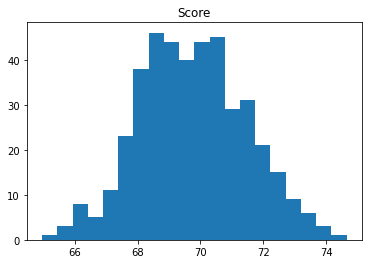

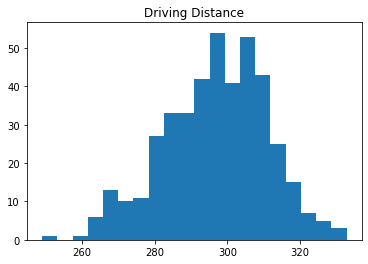

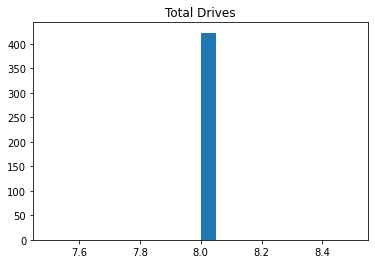

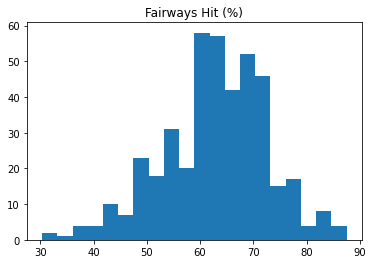

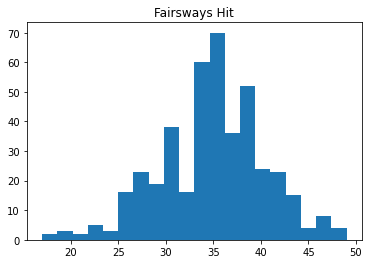

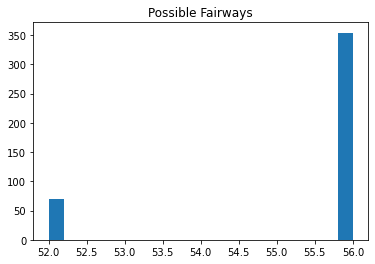

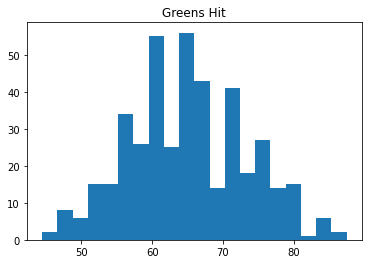

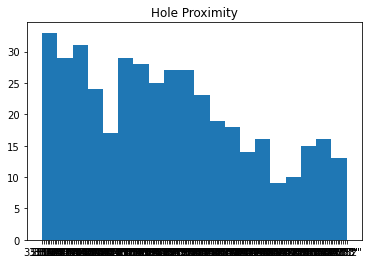

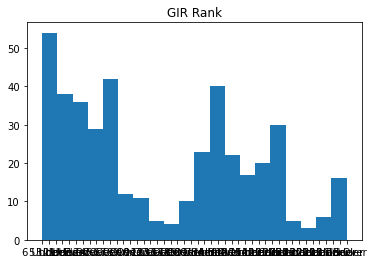

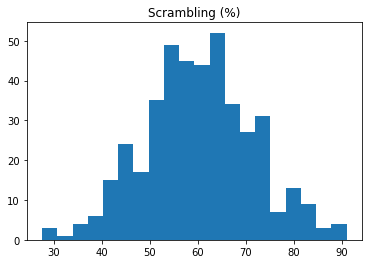

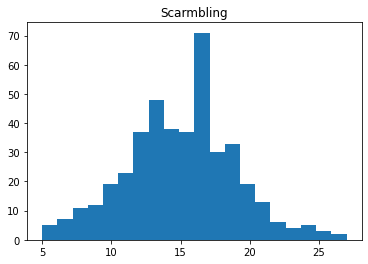

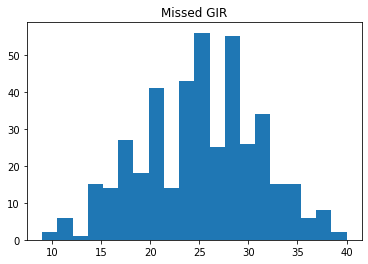

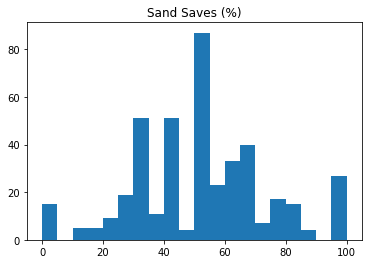

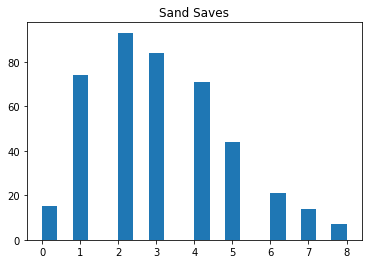

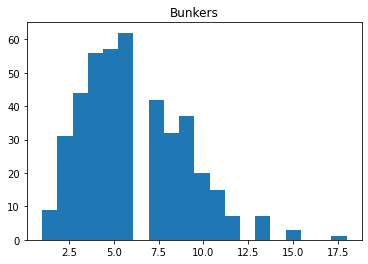

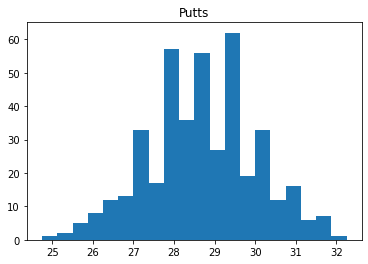

In [42]:
for i in aggratedData.columns:
    plt.hist(aggratedData[i], 20)
    plt.title(i)
    plt.show()

                      Score  Driving Distance  Total Drives  Fairways Hit (%)  \
Score              1.000000          0.092006           NaN         -0.140511   
Driving Distance   0.092006          1.000000           NaN         -0.409994   
Total Drives            NaN               NaN           NaN               NaN   
Fairways Hit (%)  -0.140511         -0.409994           NaN          1.000000   
Fairsways Hit     -0.096573         -0.425573           NaN          0.985156   
Possible Fairways  0.236604         -0.096687           NaN         -0.024545   
Greens Hit        -0.237298          0.256419           NaN          0.215172   
Scrambling (%)    -0.139250          0.129106           NaN          0.097118   
Scarmbling         0.098102         -0.151402           NaN         -0.118891   
Missed GIR         0.237292         -0.256403           NaN         -0.215189   
Sand Saves (%)    -0.219210         -0.074188           NaN          0.070242   
Sand Saves         0.101150 

<AxesSubplot:>

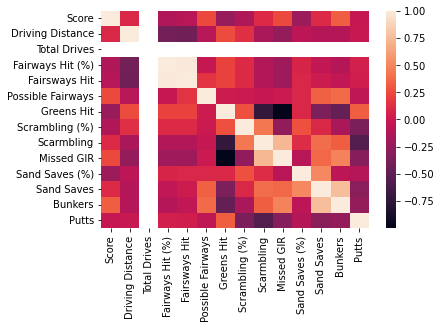

In [41]:
#look at the correlation
print(aggratedData.corr())
sns.heatmap(aggratedData.corr())

In [37]:
# I will also need to divide the data set into a 80/20 training/testing in the future
subsetDf = aggratedData.loc[:, aggratedData.columns != 'Score']
x_train = subsetDf.to_numpy()
y_train = aggratedData['Score'].to_numpy()

print(f'X: {x_train.shape}, Y: {y_train.shape}')

X: (423, 15), Y: (423,)


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3.,  3.,  9.,  4.,  5.,  6.,  7.,
         6., 19., 14., 13., 26., 23., 19., 27., 24., 33., 25., 16., 33.,
        21., 36., 30., 15., 13., 13.,  9.,  7.,  2.,  5.,  3.,  2.,  2.,
         1.]),
 array([249.   , 251.095, 253.19 , 255.285, 257.38 , 259.475, 261.57 ,
        263.665, 265.76 , 267.855, 269.95 , 272.045, 274.14 , 276.235,
        278.33 , 280.425, 282.52 , 284.615, 286.71 , 288.805, 290.9  ,
        292.995, 295.09 , 297.185, 299.28 , 301.375, 303.47 , 305.565,
        307.66 , 309.755, 311.85 , 313.945, 316.04 , 318.135, 320.23 ,
        322.325, 324.42 , 326.515, 328.61 , 330.705, 332.8  ]),
 <BarContainer object of 40 artists>)

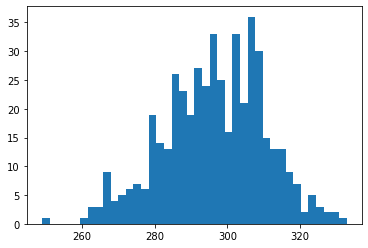

In [51]:
b_init = 10
w_init = np.array([1,1])

In [ ]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

Data Scaling with contour plots to show the change (from skinny to more circular)
- take the original verision and divide by the maxmium (1)
- mean normalization, find the mean then subtract the mean from any value and divide it by the range of possibilities
- z-score, use the std.dev and mean of each feature, (value - mean) / std.dev

*aim for all feature to range between -1 to 1, or 0<x<3 

Look into gradiant decent to mimize cost function (the amount of errors that exist in the model, for linear regression this can be the mean square error) this is limited to only find the local minima, and work on completly differentiable functions (non-peicewise), in linear regression that the function is a convex function

Learning rate implications is too small, it will take too long, too large it will overshoot the minima (fail to converge/diverge)

batch gradient descent -> each step of gradient descent looks at all training examples instead of a subset

https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/optimizing-multivariable-functions/a/what-is-gradient-descent#:~:text=Gradient%20descent%20is%20an%20algorithm,like%20we've%20seen%20before.

Look into m

$$ a \ne $$

- LaxtEX notation for math


talk about vectorization with numpy arrays (dot product) np.dot()

//PLOTS

- after each iteration of gradiate descent I should plot the values (value vs # of iterations) LEARNING CURVE
  - try with a 3x multiplier on the learning rate (alpha)
  - try with maybe 200 iterations
- automatic convergence test (use a check with an epsilion, very small value 10^-3) after each iteration check if the change is less than the epsilion